In [1]:
import requests
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch.nn.functional as F
import torch

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2-xl"
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token =  tokenizer.eos_token

In [3]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [4]:
url = 'https://rome.baulab.info/data/dsets/known_1000.json'
response = requests.get(url) 
data = response.json()

In [5]:
prompts = [dict['prompt'] for dict in data]
subjects = [' '+dict['subject'] for dict in data]
input= tokenizer(prompts, return_tensors="pt", padding= True, return_offsets_mapping= True)

In [6]:
mask = []
for j, prompt in enumerate(prompts):
    map = torch.zeros_like(input.input_ids[j], dtype=torch.int)
    for i,t in enumerate(input.offset_mapping[j]):
        
        if (prompts[j].find(subjects[j])-1<=t[0]) and (t[1]<=prompts[j].find(subjects[j])+len(subjects[j])):
            map[i] = 1
    mask.append(map)
subject_mask = torch.stack(mask)
subject_mask = torch.logical_and(subject_mask, input.attention_mask).int()
subject_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [7]:
def last_non_padding_token_logits(logits, attention_mask):
    # For each input, find the last non-padding token
    last_non_padding_logits = []
    
    for i in range(logits.size(0)):  # Loop over each prompt in the batch
        # Find the last non-padding token position
        non_padding_positions = (attention_mask[i] == 1).nonzero(as_tuple=True)[0]
        last_non_padding_token_index = non_padding_positions[-1]
        
        # Get the logits of the last non-padding token
        last_non_padding_logits.append(logits[i, last_non_padding_token_index])
    last_non_padding_logits = torch.stack(last_non_padding_logits)
    return last_non_padding_logits

In [8]:
with torch.no_grad():
    output = model(**input, labels = input.input_ids, output_hidden_states = True, output_attentions =False) 
logits = last_non_padding_token_logits(output.logits,input.attention_mask)
probs = F.softmax(logits, dim=-1)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [9]:
# prba avec clean run pour chaque prompt
probs_clean = probs.gather(1, torch.tensor(tokenizer([' '+dict['attribute'] for dict in data])['input_ids'])).squeeze()

In [10]:
# output.hidden_states[layer][prompt][token] =vecteur hidden state du token dans le prompt pour le layer

## restaured run pour le dernier token sujet

Normalement l'output d'un transformer block devrait être (nombre de prompt, nombre de token, taille d'un vecteur qui représente un token), mais bizarrement on a un tuple avec le premier element qui est bien qqchose de cette forme mais le deuxième élément est un tuple de deux truc de la forme  (nombre de prompt, a,nombre de token, b) avec ab = taille d'un vecteur qui représente un token; dans un premier temps on va juste modifier le premier élement du tuple

In [11]:
def restauration_hook(clean_states_layer, subject_mask):
    #get la last position de chaque subject token ie. lastones[prompt] donne la position du dernier token se référant au sujet
    rows, cols = torch.where(subject_mask == 1)
    last_ones = torch.full((subject_mask.size(0),), -1, dtype=torch.long)
    last_ones.scatter_reduce_(0, rows, cols, reduce="amax", include_self=False)

    prompt_indices = torch.arange(clean_states_layer.shape[0])

    def hook(module,input,output):
        restaured = output[0].clone()
        restaured[prompt_indices, last_ones] = clean_states_layer[prompt_indices, last_ones]
        return (restaured,output[1])
    return hook

In [12]:
def noise_hook(subject_mask):
    def hook(module,input,output):
        std_dev_all = torch.std(output.flatten())
        noise = torch.randn_like(output)*3*std_dev_all
        noisy_output = output + noise * subject_mask.unsqueeze(-1).float()
        return noisy_output
    return hook

In [13]:
noise = model.transformer.wpe.register_forward_hook(noise_hook(subject_mask))

In [14]:
with torch.no_grad():
    output_logits = model(**input, labels = input.input_ids, output_hidden_states = False, output_attentions =False).logits
logits = last_non_padding_token_logits(output_logits,input.attention_mask)
probs = F.softmax(logits, dim=-1)
probs_corrupt = probs.gather(1, torch.tensor(tokenizer([' '+dict['attribute'] for dict in data])['input_ids'])).squeeze()

In [15]:
probs_restaur = []
for l in range(len(model.transformer.h)):
    hook_l = model.transformer.h[l].register_forward_hook(restauration_hook(output.hidden_states[l+1], subject_mask))   #on met l+1 dans hidden states 
                                                                                                                        #car hidden states comprend aussi 
                                                                                                                        #la sortie de l'embedding (il me semble)
    with torch.no_grad():
        output_logits = model(**input, labels = input.input_ids, output_hidden_states = False, output_attentions =False).logits
    logits = last_non_padding_token_logits(output_logits,input.attention_mask)
    probs = F.softmax(logits, dim=-1)
    probs_restaur.append( probs.gather(1, torch.tensor(tokenizer([' '+dict['attribute'] for dict in data])['input_ids'])).squeeze() ) 
    hook_l.remove()
    print(f'layer {l} fait')
    output_logits = None
    logits = None
    probs = None



layer 0 fait
layer 1 fait
layer 2 fait
layer 3 fait
layer 4 fait
layer 5 fait
layer 6 fait
layer 7 fait
layer 8 fait
layer 9 fait
layer 10 fait
layer 11 fait
layer 12 fait
layer 13 fait
layer 14 fait
layer 15 fait
layer 16 fait
layer 17 fait
layer 18 fait
layer 19 fait
layer 20 fait
layer 21 fait
layer 22 fait
layer 23 fait
layer 24 fait
layer 25 fait
layer 26 fait
layer 27 fait
layer 28 fait
layer 29 fait
layer 30 fait
layer 31 fait
layer 32 fait
layer 33 fait
layer 34 fait
layer 35 fait
layer 36 fait
layer 37 fait
layer 38 fait
layer 39 fait
layer 40 fait
layer 41 fait
layer 42 fait
layer 43 fait
layer 44 fait
layer 45 fait
layer 46 fait
layer 47 fait


In [16]:
for i,a in enumerate(probs_restaur):
    AIE = a.mean()-probs_corrupt.mean()
    print(f"{round(AIE.item()*100,2)} % : AIE du layer {i} (bloc transformer)")

2.89 % : AIE du layer 0 (bloc transformer)
5.29 % : AIE du layer 1 (bloc transformer)
3.58 % : AIE du layer 2 (bloc transformer)
2.23 % : AIE du layer 3 (bloc transformer)
4.95 % : AIE du layer 4 (bloc transformer)
4.67 % : AIE du layer 5 (bloc transformer)
6.5 % : AIE du layer 6 (bloc transformer)
5.36 % : AIE du layer 7 (bloc transformer)
5.17 % : AIE du layer 8 (bloc transformer)
5.35 % : AIE du layer 9 (bloc transformer)
5.14 % : AIE du layer 10 (bloc transformer)
5.33 % : AIE du layer 11 (bloc transformer)
6.75 % : AIE du layer 12 (bloc transformer)
7.24 % : AIE du layer 13 (bloc transformer)
5.68 % : AIE du layer 14 (bloc transformer)
6.04 % : AIE du layer 15 (bloc transformer)
5.36 % : AIE du layer 16 (bloc transformer)
5.24 % : AIE du layer 17 (bloc transformer)
2.97 % : AIE du layer 18 (bloc transformer)
3.85 % : AIE du layer 19 (bloc transformer)
4.81 % : AIE du layer 20 (bloc transformer)
3.92 % : AIE du layer 21 (bloc transformer)
1.81 % : AIE du layer 22 (bloc transformer)

## restaured run pour le premier token sujet

il s'agit d'une simple adaption de ce qui a été fait avant

In [17]:
def restauration_first_subject_hook(clean_states_layer, subject_mask):
    # Get la first position de chaque subject token ie. first_ones[prompt] donne la position du premier token se référant au sujet
    rows, cols = torch.where(subject_mask == 1)
    first_ones = torch.full((subject_mask.size(0),), -1, dtype=torch.long)
    first_ones.scatter_reduce_(0, rows, cols, reduce="amin", include_self=False) 

    prompt_indices = torch.arange(clean_states_layer.shape[0])

    def hook(module, input, output):
        restaured = output.clone()  # Correction ici : output[0] -> output
        restaured[prompt_indices, first_ones] = clean_states_layer[prompt_indices, first_ones]
        return restaured
    
    return hook

In [18]:
probs_restaur_first_subject = []
for l in range(len(model.transformer.h)):
    hook_l = model.transformer.h[l].register_forward_hook(restauration_hook(output.hidden_states[l+1], subject_mask))   #on met l+1 dans hidden states 
                                                                                                                        #car hidden states comprend aussi 
                                                                                                                        #la sortie de l'embedding (il me semble)
    with torch.no_grad():
        output_logits = model(**input, labels = input.input_ids, output_hidden_states = False, output_attentions =False).logits
    logits = last_non_padding_token_logits(output_logits,input.attention_mask)
    probs = F.softmax(logits, dim=-1)
    probs_restaur_first_subject.append( probs.gather(1, torch.tensor(tokenizer([' '+dict['attribute'] for dict in data])['input_ids'])).squeeze() ) 
    hook_l.remove()
    print(f'layer {l} fait')
    output_logits = None
    logits = None
    probs = None

layer 0 fait
layer 1 fait
layer 2 fait
layer 3 fait
layer 4 fait
layer 5 fait
layer 6 fait
layer 7 fait
layer 8 fait
layer 9 fait
layer 10 fait
layer 11 fait
layer 12 fait
layer 13 fait
layer 14 fait
layer 15 fait
layer 16 fait
layer 17 fait
layer 18 fait
layer 19 fait
layer 20 fait
layer 21 fait
layer 22 fait
layer 23 fait
layer 24 fait
layer 25 fait
layer 26 fait
layer 27 fait
layer 28 fait
layer 29 fait
layer 30 fait
layer 31 fait
layer 32 fait
layer 33 fait
layer 34 fait
layer 35 fait
layer 36 fait
layer 37 fait
layer 38 fait
layer 39 fait
layer 40 fait
layer 41 fait
layer 42 fait
layer 43 fait
layer 44 fait
layer 45 fait
layer 46 fait
layer 47 fait


## restaured run pour le dernier token 

In [19]:
def restauration_last_token_hook(clean_states_layer, attention_mask):
    #get la last position de chaque subject token ie. lastones[prompt] donne la position du dernier token se référant au sujet
    rows, cols = torch.where(attention_mask == 1)
    last_ones = torch.full((attention_mask.size(0),), -1, dtype=torch.long)
    last_ones.scatter_reduce_(0, rows, cols, reduce="amax", include_self=False)

    prompt_indices = torch.arange(clean_states_layer.shape[0])

    def hook(module,input,output):
        restaured = output[0].clone()
        restaured[prompt_indices, last_ones] = clean_states_layer[prompt_indices, last_ones]
        return (restaured,output[1])
    return hook

In [20]:
probs_restaur_last_token = []
for l in range(len(model.transformer.h)):
    hook_l = model.transformer.h[l].register_forward_hook(restauration_hook(output.hidden_states[l+1], input.attention_mask))   #on met l+1 dans hidden states 
                                                                                                                        #car hidden states comprend aussi 
                                                                                                                        #la sortie de l'embedding (il me semble)
    with torch.no_grad():
        output_logits = model(**input, labels = input.input_ids, output_hidden_states = False, output_attentions =False).logits
    logits = last_non_padding_token_logits(output_logits,input.attention_mask)
    probs = F.softmax(logits, dim=-1)
    probs_restaur_last_token.append( probs.gather(1, torch.tensor(tokenizer([' '+dict['attribute'] for dict in data])['input_ids'])).squeeze() ) 
    hook_l.remove()
    print(f'layer {l} fait')
    output_logits = None
    logits = None
    probs = None

layer 0 fait
layer 1 fait
layer 2 fait
layer 3 fait
layer 4 fait
layer 5 fait
layer 6 fait
layer 7 fait
layer 8 fait
layer 9 fait
layer 10 fait
layer 11 fait
layer 12 fait
layer 13 fait
layer 14 fait
layer 15 fait
layer 16 fait
layer 17 fait
layer 18 fait
layer 19 fait
layer 20 fait
layer 21 fait
layer 22 fait
layer 23 fait
layer 24 fait
layer 25 fait
layer 26 fait
layer 27 fait
layer 28 fait
layer 29 fait
layer 30 fait
layer 31 fait
layer 32 fait
layer 33 fait
layer 34 fait
layer 35 fait
layer 36 fait
layer 37 fait
layer 38 fait
layer 39 fait
layer 40 fait
layer 41 fait
layer 42 fait
layer 43 fait
layer 44 fait
layer 45 fait
layer 46 fait
layer 47 fait


## tracée de la heat map des AIE en fonction des layers et des tokens ou on corriges

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

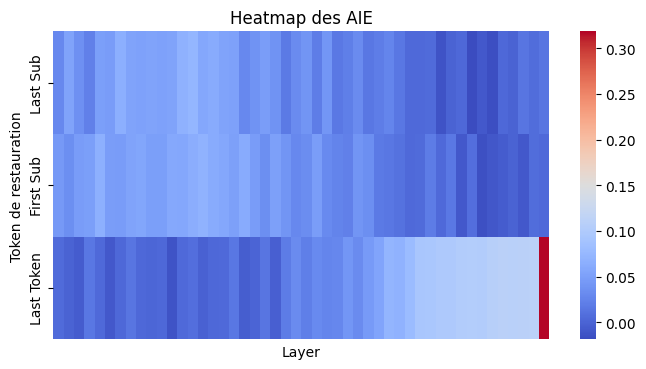

In [22]:
AIE_restaur_last_sub = torch.tensor([a.mean().item() for a in probs_restaur]) - probs_corrupt.mean().item()
AIE_restaur_first_sub = torch.tensor([a.mean().item() for a in probs_restaur_first_subject]) - probs_corrupt.mean().item()
AIE_restaur_last_token = torch.tensor([a.mean().item() for a in probs_restaur_last_token]) - probs_corrupt.mean().item()

# Conversion en NumPy pour la heatmap
data_heatmap = np.vstack([
    AIE_restaur_last_sub.cpu().numpy(),
    AIE_restaur_first_sub.cpu().numpy(),
    AIE_restaur_last_token.cpu().numpy()
])

# Tracé de la heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(data_heatmap, annot=False, cmap="coolwarm", xticklabels=False, yticklabels=["Last Sub", "First Sub", "Last Token"])

# Titres et labels
plt.title("Heatmap des AIE")
plt.xlabel("Layer")
plt.ylabel("Token de restauration")

# Afficher la heatmap
plt.show()

In [26]:
import pandas as pd
data = {
    "AIE_restaur_last_sub": AIE_restaur_last_sub.numpy(),
    "AIE_restaur_first_sub": AIE_restaur_first_sub.numpy(),
    "AIE_restaur_last_token": AIE_restaur_last_token.numpy(),
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Save to an Excel file
df.to_excel("AIE.xlsx", index=False)
